# Calculate geometric elements, given cross-sectional survey

Import necessary libraries

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy import integrate
from scipy.optimize import fmin
import pandas as pd
from math import hypot
from scipy.optimize import curve_fit
import matplotlib.image as mpimg
from sklearn.metrics import r2_score

Import survey, in csv format

In [3]:
# for irregular cross section:
# import csv of surveys
fname1 = "xs1.csv" # define file name, must be in working directory
xs1 = pd.read_csv(fname1) # read into pandas dataframe
x = xs1['Station (m)'] # define x as station, depends on actual collumn name
y = xs1['Elev (m)'] # define y as elevation, depends on actual collumn name (execute xs1.columns for dataframe column names)

Calculate spatial stats for many different depths

In [4]:
# calculate cross sectional area for several WSE
f2 = interp1d(x, y, kind='cubic') # use cubic interpolation to define continuous ground function

xnew = np.linspace(min(x), max(x), num=1000, endpoint=True) # create index array for x
ynew = np.linspace(min(y), max(y), num=100, endpoint=True) # create index array for y
area = []
depth = []
p = []

# define function to calculate wetted perimeter
## https://stackoverflow.com/questions/46098157/how-to-calculate-the-length-of-a-curve-of-a-math-function
def arclength(f, a, b, tol=1e-6):
    nsteps = 1  # number of steps to compute
    oldlength = 1.0e20
    length = 1.0e10
    while abs(oldlength - length) >= tol:
        nsteps *= 2
        fx1 = f(a)
        xdel = (b - a) / nsteps  # space between x-values
        oldlength = length
        length = 0
        for i in range(1, nsteps + 1):
            fx0 = fx1  # previous function value
            fx1 = f(a + i * (b - a) / nsteps)  # new function value
            length += hypot(xdel, fx1 - fx0)  # length of small line segment
    return length

# calculate area
for i in ynew:
    y_0=[i for j in range(1000)] # create water surface array
    idx = np.argwhere(np.diff(np.sign(f2(xnew) - y_0))).flatten() # find intersection between water surface and cross section
    auc = integrate.quad(f2, (xnew[min(idx)]), (xnew[max(idx)])) # find area under xs curve
    rec = (max(xnew[idx])-min(xnew[idx]))*i # find area in rectangle 
    xsa = rec-auc[0] # subtract auc from rectangle to find area in cross section
    area.append(xsa)
    p.append(arclength(f2, (xnew[min(idx)]), (xnew[max(idx)]), 1e-3))

# find depth to lowest point or thalweg
t = min(y) # define thalweg elevation
t = [t for i in ynew]    
depth = ynew-t 

# calculate hydraulic radius
R = [i / j for i, j in zip(area, p)]

C:\Users\GSCOB\AppData\Local\Temp\ipykernel_12548\1727180458.py:44: RuntimeWarning: invalid value encountered in double_scalars
  R = [i / j for i, j in zip(area, p)]


In [5]:
# get rid of values if water level higher than ground
area = [i for i in area if i>0]
depth = [depth[i] for i in range(len(area))]
R = [R[i] for i in range(len(area))]
p = [p[i] for i in range(len(area))]

Look at what we have

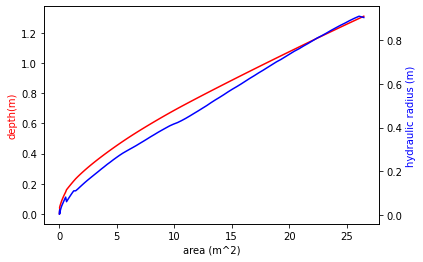

In [6]:
fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax1.plot(area, depth,'r')
ax2.plot(area, R,'b')

ax1.set_xlabel('area (m^2)')
ax1.set_ylabel('depth(m)',color='r')
ax2.set_ylabel('hydraulic radius (m)',color='b')

plt.show()

Curve fit for area vs depth and depth vs R <br>
cite: https://stackoverflow.com/questions/41109122/fitting-a-curve-to-a-power-law-distribution-with-curve-fit-does-not-work

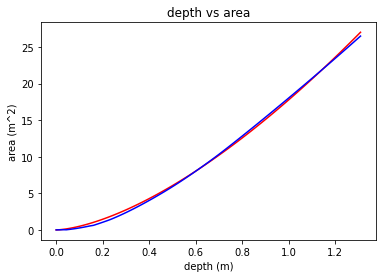

r^2 for depth vs area curve 0.9990564664478153
a1 is 17.77565081180806 and a2 is 1.5542577268860134


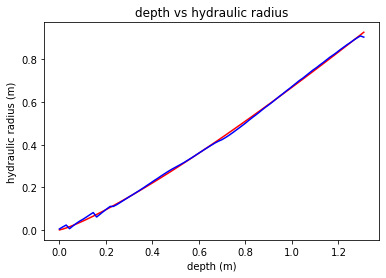

r^2 for depth vs hydraulic radius 0.9993987277753528
r1 is 0.669210869486568 and r2 is 1.2122579717587576


In [26]:
# create power relationship between depth and area
def func(x, m, c):
    return c*x**m

popt, pcov = curve_fit(func, depth, area)
fig, ax = plt.subplots()
plt.plot(depth, func(depth, *popt), 'r-')
plt.plot(depth,area,'b-')
ax.set_xlabel('depth (m)')
ax.set_ylabel('area (m^2)')
plt.title('depth vs area')
plt.show()

y_true = area
y_pred = func(depth, *popt)
print('r^2 for depth vs area curve' ,r2_score(y_true, y_pred))
print('a1 is',popt[1],'and a2 is',popt[0])

# create power relationship between depth and R

popt1, pcov1 = curve_fit(func, depth, R)
fig, ax = plt.subplots()
plt.plot(depth, func(depth, *popt1), 'r-')
plt.plot(depth,R,'b-')
ax.set_xlabel('depth (m)')
ax.set_ylabel('hydraulic radius (m)')
plt.title('depth vs hydraulic radius')
plt.show()

y_true1 = R
y_pred1 = func(depth, *popt1)
print('r^2 for depth vs hydraulic radius' ,r2_score(y_true1, y_pred1))
print('r1 is',popt1[1],'and r2 is',popt1[0])